<a href="https://colab.research.google.com/github/RoetGer/generalized-t-process-regression/blob/main/gen_t_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gpflow

     |████████████████████████████████| 276kB 6.9MB/s 


In [36]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

'2.5.0'

In [3]:
df = 3.
loc = tf.Variable([1., 2., 3.])
scale = [[ 0.6,  0. ,  0. ],
         [ 0.2,  0.5,  0. ],
         [ 0.1, -0.3,  0.4]]
scale = tf.linalg.LinearOperatorLowerTriangular(scale)

mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=loc,
    scale=scale)

In [4]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    density = mvt.prob([0., 0., 0.])
  gradient = inner_tape.gradient(density, mvt.trainable_variables[0])

outer_tape.jacobian(gradient, mvt.trainable_variables[0])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 6.9320464e-07, -7.5581365e-06, -9.2025548e-06],
       [-7.5581352e-06,  1.9834491e-05,  2.5120040e-05],
       [-9.2025539e-06,  2.5120042e-05,  2.7110138e-05]], dtype=float32)>

In [5]:
mvt.trainable_variables

(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>,)

In [6]:
loc.shape

TensorShape([3])

### GPflow - Binary Classification

Foundation taken from [GPflow binary classification model](https://gpflow.readthedocs.io/en/master/notebooks/basics/classification.html)

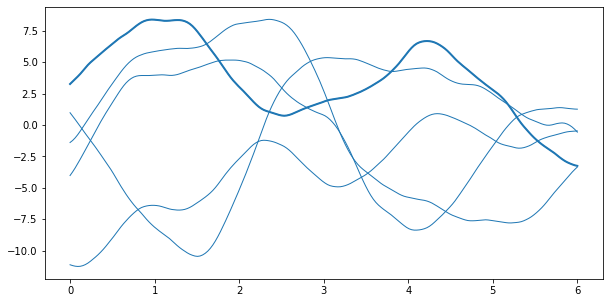

In [6]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

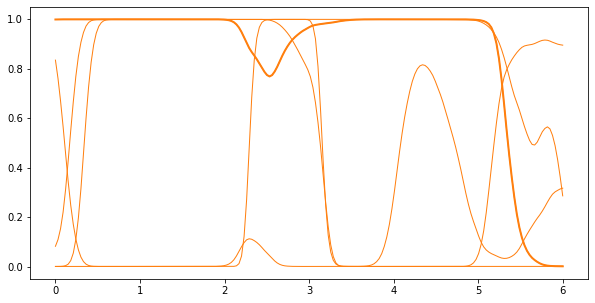

In [7]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()


p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C1", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)

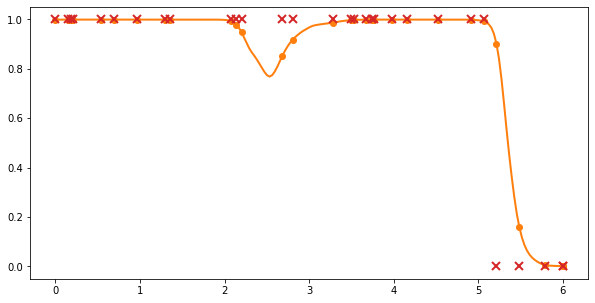

In [8]:
# Select some input locations
ind = rng.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get Bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = rng.binomial(1, p)

# plot
plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)
plt.plot(X_gen, p, "C1o", ms=6)
_ = plt.plot(X_gen, Y_gen, "C3x", ms=8, mew=2)

In [10]:
m = gpflow.models.VGP(
    (X_gen, Y_gen), likelihood=gpflow.likelihoods.Bernoulli(), kernel=gpflow.kernels.Matern52()
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 5.921130177394291
 hess_inv: <497x497 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.78253795e-04, -1.61809166e-06,  7.97288934e-05, -2.56457370e-05,
       -3.19435981e-04, -9.77303768e-05,  3.65503836e-06, -3.55404475e-05,
        1.51691560e-06,  2.60414254e-06, -5.66910904e-07,  6.83518424e-07,
       -4.84583134e-06, -8.26329395e-07, -7.74970114e-06,  6.64908570e-06,
       -2.58952853e-07, -1.15593266e-05, -4.40631564e-07,  4.90943344e-07,
       -5.01536929e-09, -2.33588387e-09, -2.40253319e-06,  1.37008530e-07,
       -3.01552016e-07, -3.93965023e-07, -2.99033797e-08, -3.87416728e-08,
       -3.92586551e-08,  2.05379648e-08,  2.92843059e-06, -8.10135283e-08,
       -8.38028936e-08,  6.45942925e-16,  4.92766267e-11,  3.41825071e-15,
        5.14826996e-14, -3.38859041e-13,  1.52259895e-13,  9.40644512e-09,
       -2.80741643e-09,  6.83393397e-09,  5.31380897e-16, -2.47080565e-11,
        5.19857243e-13,  4.81490492e-09, -2.39469898e-08, -7.80634456e-10,


In [ ]:
with tf.GradientTape() as tape:
  mll = m.maximum_log_likelihood_objective()

tape.jacobian(mll, m.trainable_variables)

In [19]:
with tf.GradientTape() as tape:
  mll = m.maximum_log_likelihood_objective()

tape.jacobian(mll, m.trainable_variables)

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.0006782537950324869>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1.6180916639517082e-06>,
 <tf.Tensor: shape=(30, 1), dtype=float64, numpy=
 array([[-7.97288933e-05],
        [ 2.56457371e-05],
        [ 3.19435981e-04],
        [ 9.77303768e-05],
        [-3.65503832e-06],
        [ 3.55404475e-05],
        [-1.51691556e-06],
        [-2.60414263e-06],
        [ 5.66913409e-07],
        [-6.83516621e-07],
        [ 4.84583190e-06],
        [ 8.26326640e-07],
        [ 7.74969984e-06],
        [-6.64908525e-06],
        [ 2.58957952e-07],
        [ 1.15593265e-05],
        [ 4.40630750e-07],
        [-4.90941244e-07],
        [ 5.03461000e-09],
        [ 2.31608161e-09],
        [ 2.40253422e-06],
        [-1.36969713e-07],
        [ 3.01560453e-07],
        [ 3.93973749e-07],
        [ 2.98652451e-08],
        [ 3.87856420e-08],
        [ 3.92269951e-08],
        [-2.05286219e-08],
        [-2.92843273e-06],
        [ 8.10136399e-08]])>,

### TP Binary Classification

In [ ]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

In [44]:
### Sample from TP
# Based on https://journal.r-project.org/archive/2013/RJ-2013-033/RJ-2013-033.pdf
nu = 5

k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 400).reshape(-1, 2)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)
f_grid = np.dot(L, rng.randn(200, 5))

L = np.linalg.cholesky(K)

chi2 = tfd.Chi2(df=nu)
samples_chi2 = chi2.sample(sample_shape=x_grid.shape[0])

scaler = tf.sqrt(nu/samples_chi2)
scaler = tf.reshape(scaler, shape=(-1,1))

t_samples = tf.multiply(scaler, f_grid)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  after removing the cwd from sys.path.


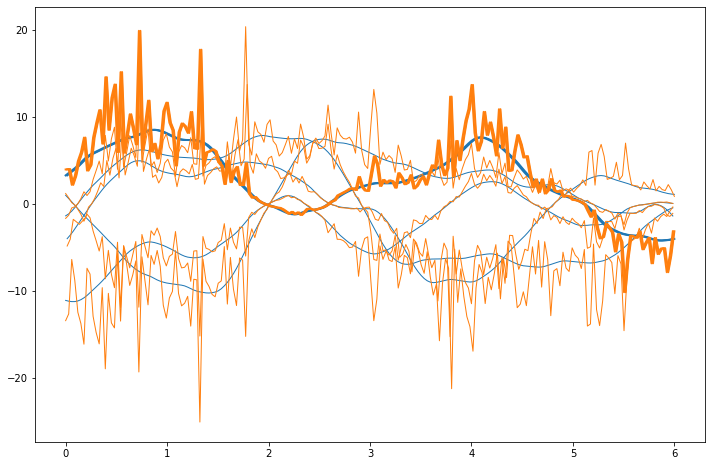

In [45]:
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)
_ = plt.plot(x_grid, t_samples[:, 1], "C1", linewidth=2)
_ = plt.plot(x_grid, t_samples, "C1", linewidth=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  del sys.path[0]


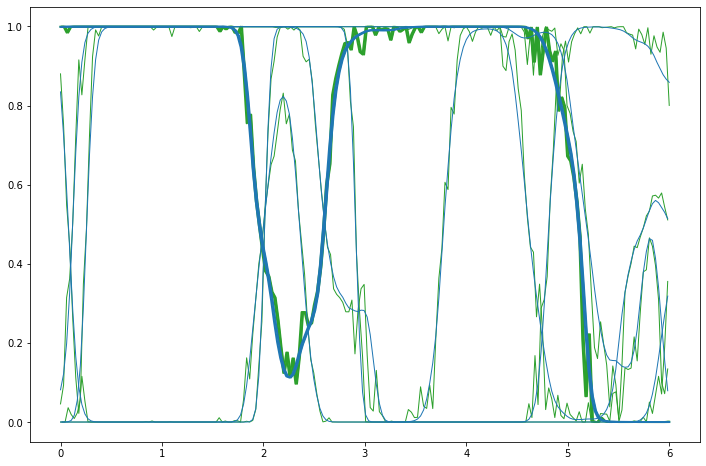

In [46]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()


p_grid = invlink(t_samples)
plt.plot(x_grid, p_grid, "C2", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C2", linewidth=2)

p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C0", linewidth=2)

In [ ]:
tf.

In [22]:
tf.multiply(scaler, x_grid)

InvalidArgumentError: ignored

In [15]:
nu = 2


tf.sqrt(nu/chi2.sample(sample_shape=x_grid.shape[0]))



<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 1.3007921 ,  0.5945616 ,  4.140359  ,  0.5236784 ,  1.0546414 ,
        2.3277607 ,  0.6428949 ,  0.87101114,  2.139834  ,  1.0765688 ,
        0.48967543,  0.83307487,  1.4357847 ,  0.84297323,  1.4021976 ,
        2.0693488 ,  0.7149594 ,  2.031121  ,  0.90849364,  1.0859494 ,
        1.3602829 ,  1.5546957 ,  1.1186092 ,  2.6291556 ,  1.5865874 ,
        1.2005293 ,  3.746406  ,  1.9046172 ,  0.9871173 ,  1.5947839 ,
        1.053179  ,  2.8627064 ,  3.998484  ,  0.9493354 ,  2.3621824 ,
        0.5116686 ,  1.1282829 ,  1.2950402 ,  2.1322181 ,  0.9792082 ,
        2.082827  ,  0.55384165,  1.8508312 ,  3.751865  ,  8.078958  ,
        0.9400194 ,  1.6236022 ,  8.167329  ,  0.4386076 ,  0.9109911 ,
        1.3400762 ,  1.1491632 ,  0.63242054,  1.521914  ,  1.314498  ,
        0.592963  ,  0.6141043 ,  2.804778  ,  0.6605994 ,  0.9502515 ,
        0.7335708 ,  1.1584921 ,  0.72806495,  4.295151  ,  1.6300067 ,
        3.666576